# TM10007 Assignment template

In [1]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [55]:
# Data loading functions. Uncomment the one you want to use
# Import other classifiers you plan to use
from worclipo.load_data import load_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind  # for independent t-test



data = load_data()
print(f"The number of samples: {len(data.index)}")
print(f"The number of columns: {len(data.columns)}")
print(f"The number of liposarcoma in the dataset: {len(data[data['label'] == 'liposarcoma'])}")
print(f"The number of lipoma in the dataset: {len(data[data['label'] == 'lipoma'])}")

The number of samples: 115
The number of columns: 494
The number of liposarcoma in the dataset: 58
The number of lipoma in the dataset: 57


Nullen eruit

In [57]:
'''deleting all the columns consisting of only 0's'''

# find the column that contains only zeros
zero_columns = data.columns[data.eq(0).all()]

# Drop columns with only zeros
data_whithout_0 = data.drop(zero_columns,axis=1)

Now we know the number of samples, colums and labels. The next step is to look for missing data. 


In [59]:
def split_data(data):

    # Separate features and target variable
    x = data.drop(['label'], axis=1)
    y = data['label']
    
    # Split the dataset into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    
    return x_train, x_test, y_train, y_test, x, y


# Call the function
x_train, x_test, y_train, y_test, x, y = split_data(data)

# y_train_bin = binner(y_train, 'liposarcoma') # make binary y_score
# y_test_bin = binner(y_test, 'liposarcoma')

# Optionally, print the sizes of the splits to verify
print("Training set size:", x_train.shape)
print("Testing set size:", x_test.shape)


Training set size: (92, 493)
Testing set size: (23, 493)


Scaling fucntion

In [8]:
def scaling_data(x_train,x_test):
    scaler = preprocessing.StandardScaler().fit(x_train)

    # Applying scaler to train and test set
    X_train_scaled = pd.DataFrame(scaler.transform(x_train), index=x_train.index, columns=x_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(x_test), index=x_test.index, columns=x_test.columns)

    return X_train_scaled, X_test_scaled

X_train_scaled, X_test_scaled = scaling_data(x_train, x_test)


Mann whitney U test

In [67]:
from scipy.stats import mannwhitneyu
def manual_feature_selection_ttest(X_train_scaled, y_train):
    '''defiition to calculate the Ttest and P-value of every feature
    input: x_train, y_train
    output: beste 5 festures'''
    w
    lipoma = X_train_scaled[y_train =='lipoma']
    liposarcoma = X_train_scaled[y_train =='liposarcoma']

    wc_result = pd.DataFrame(columns=['statistic', 'p_value'])
    for feature in X_train_scaled.columns:
        statistic, p_value = mannwhitneyu(lipoma[feature], liposarcoma[feature])
        feature_result = pd.DataFrame({'statistic': statistic, 'p_value': p_value}, index = [feature])
        wc_result = pd.concat([wc_result, feature_result])
    return wc_result

def select_features_by_p_value(wc_result, alpha=0.05):
    '''Definition to select features based on p-value threshold of 0.05'''

    selected_features = wc_result[wc_result['p_value'] < alpha].index
    selected_features_df = X_train_scaled[selected_features]
    
    return selected_features_df

selected_features_df = select_features_by_p_value(wc_result, alpha=0.05)

print(selected_features_df.shape)


(92, 107)


PCA on mann whitney U test

In [94]:
def apply_pca_with_variance(X, min_variance):
    '''Definition to apply PCA for dimensionality reduction until a desired variance is achieved'''
    
    pca = PCA()
    X_pca = pca.fit_transform(X)
    explained_variance_ratios = pca.explained_variance_ratio_
    
    # Accumulate explained variances until reaching the desired threshold
    cumulative_variance_ratio = 0.0
    n_components = 0
    for variance_ratio in explained_variance_ratios:
        cumulative_variance_ratio += variance_ratio
        n_components += 1
        if cumulative_variance_ratio >= min_variance:
            break
    
    # Fit PCA again with the selected number of components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    X_pca_df = pd.DataFrame(X_pca)

    # Print the total explained variance ratio and the number of components
    print("Total explained variance ratio:", cumulative_variance_ratio)
    print("Number of components:", n_components)

    # Obtain eigenvalues
    eigenvalues = pca.explained_variance_
    print("Eigenvalues:", eigenvalues)
    
    return X_pca_df

min_variance_ratio = 0.89  # 89% of the total explained variance ratio
X_pca_df = apply_pca_with_variance(selected_features_df, min_variance_ratio)

Total explained variance ratio: 0.8913097285714958
Number of components: 18
Eigenvalues: [39.30815983 12.47999444  6.44059373  5.6582602   4.39866178  3.80887186
  3.67827956  3.01080285  2.92349746  2.24742549  2.09845154  1.98828042
  1.7596284   1.56823607  1.53549664  1.25735486  1.14718509  1.10898425]


PLOT pca

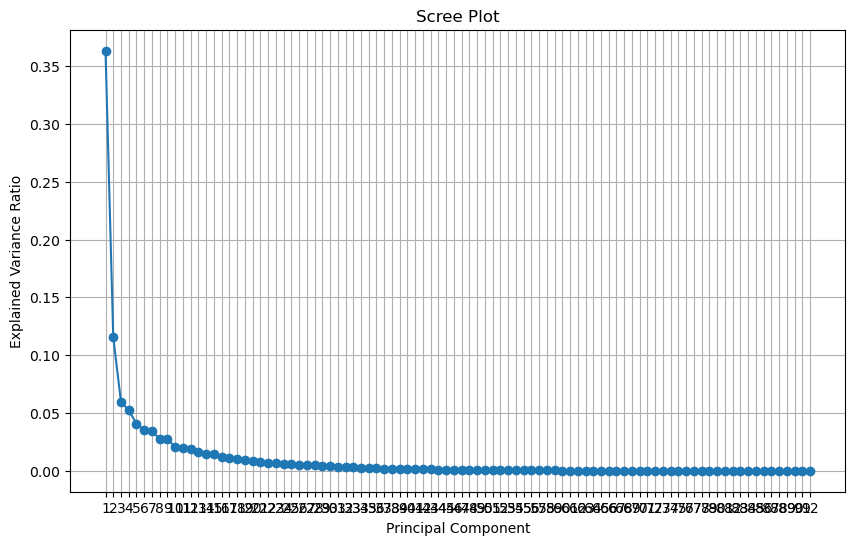

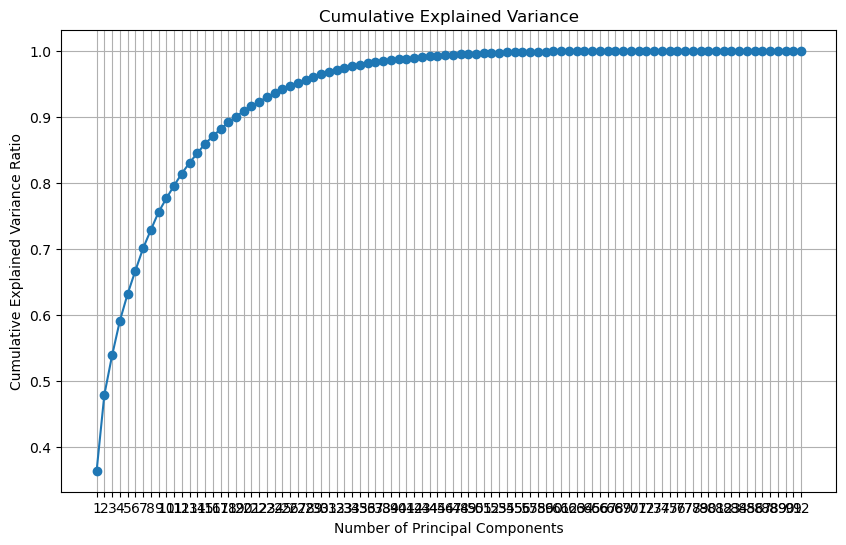

In [76]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scree_plot(pca):
    '''
    Plot the scree plot showing the explained variance for each principal component.
    '''
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o', linestyle='-')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.xticks(np.arange(1, pca.n_components_ + 1))
    plt.grid(True)
    plt.show()

def plot_cumulative_explained_variance(pca):
    '''
    Plot the cumulative explained variance plot showing the cumulative explained variance ratio.
    '''
    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, pca.n_components_ + 1), cumulative_explained_variance, marker='o', linestyle='-')
    plt.title('Cumulative Explained Variance')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.xticks(np.arange(1, pca.n_components_ + 1))
    plt.grid(True)
    plt.show()

# Assuming X_pca_df contains the transformed data after PCA
# Apply PCA for dimensionality reduction
pca = PCA()
X_pca = pca.fit_transform(selected_features_df)

# Plot scree plot
plot_scree_plot(pca)

# Plot cumulative explained variance plot
plot_cumulative_explained_variance(pca)

T-Test

In [10]:
def manual_feature_selection_ttest(X_train_scaled, y_train):
    '''defiition to calculate the Ttest and P-value of every feature
    input: x_train_scaled, y_train
    output: beste 5 festures'''
    
    lipoma = X_train_scaled[y_train =='lipoma']
    liposarcoma = X_train_scaled[y_train =='liposarcoma']

    Ttest_indResult = pd.DataFrame(columns=['t_statistic', 'p_value'])
    for feature in X_train_scaled.columns:
        t_statistic, p_value = ttest_ind(lipoma[feature], liposarcoma[feature])
        feature_result = pd.DataFrame({'t_statistic': t_statistic, 'p_value': p_value}, index = [feature])
        Ttest_indResult = pd.concat([Ttest_indResult, feature_result])

    absolute_features = Ttest_indResult['t_statistic'].abs()
    best_5_features = absolute_features.nlargest(5)
    best_5_features_index = best_5_features.index.tolist()
    df_best_5_features = pd.DataFrame(X_train_scaled[best_5_features_index])
    return df_best_5_features

df_best_5_features = manual_feature_selection_ttest(X_train_scaled, y_train)
#print(df_best_5_features)


C:\Users\riann\AppData\Local\Temp\ipykernel_13508\1761534922.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Ttest_indResult = pd.concat([Ttest_indResult, feature_result])
c:\Users\riann\miniconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\riann\miniconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*

c:\Users\riann\miniconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\riann\miniconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\riann\miniconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\riann\miniconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occ

In [48]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree_feature_selection_dt(X_train_scaled, y_train, n_features=5):
    '''Select top features using a decision tree classifier.
    
    Args:
    - X_train_scaled: Scaled training features
    - y_train: Training labels
    - n_features: Number of top features to select
    
    Returns:
    - DataFrame containing the selected top features
    '''
    # Initialize decision tree classifier
    clf = DecisionTreeClassifier(random_state=1)
    
    # Fit the classifier
    clf.fit(X_train_scaled, y_train)
    
    # Get feature importances
    feature_importances = clf.feature_importances_
    
    # Get indices of top features
    top_feature_indices = feature_importances.argsort()[-n_features:][::-1]
    
    # Select top features
    top_features_dt = X_train_scaled.columns[top_feature_indices]
    
    # Return DataFrame containing the selected top features
    return X_train_scaled[top_features_dt]

# Use the function to select top features
df_top_features_dt = decision_tree_feature_selection_dt(X_train_scaled, y_train)
print(df_top_features_dt.shape)

(92, 5)


Lasso regression

In [43]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder

def lasso_feature_selection(X_train_scaled, y_train, alpha=1.0):
    '''
    Definition to perform feature selection using Lasso regression.
    Input: X_train_scaled, y_train, alpha (regularization parameter)
    Output: DataFrame containing the selected features
    '''
    # Encode the target variable
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)

    # Initialize Lasso estimator
    lasso = Lasso(alpha=alpha)

    # Fit Lasso model
    lasso.fit(X_train_scaled, y_train_encoded)

    # Get selected features
    selected_features_mask = lasso.coef_ != 0
    selected_features = X_train_scaled.columns[selected_features_mask]

    # Filter the dataset to retain only selected features
    df_selected_features = pd.DataFrame(X_train_scaled[selected_features])

    return df_selected_features, y_train_encoded

# Example usage:
df_selected_features = lasso_feature_selection(X_train_scaled, y_train)
print(df_selected_features.shape)

AttributeError: 'tuple' object has no attribute 'shape'

Lasso regression 2.0

c:\Users\riann\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.324e+00, tolerance: 1.980e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\riann\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.324e+00, tolerance: 1.980e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\riann\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.324e+00, toler

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

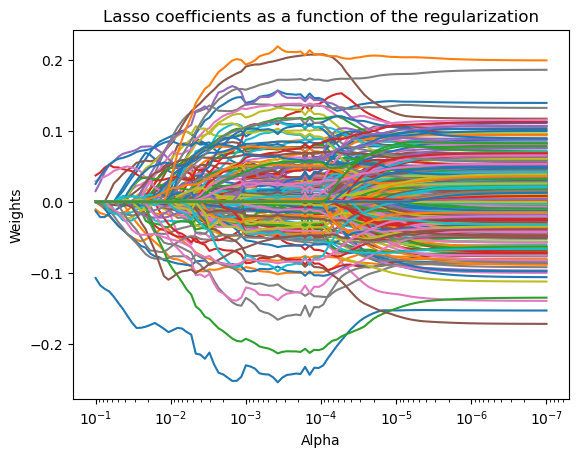

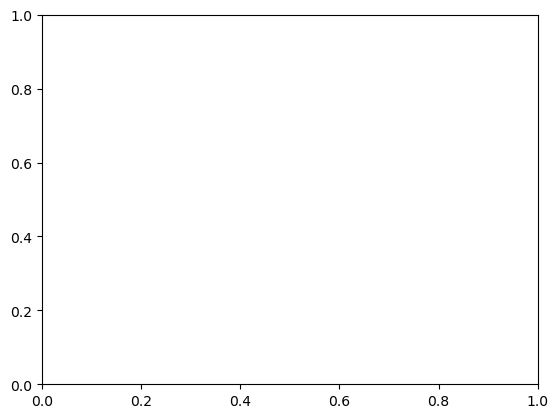

In [49]:
RAND_STATE = 42 # Constant for random_state, uncomment for same outcomes as in the report
fig_dir = 'xxxx' # Directory for saving figures, when using visual studio code

coefs = []
accuracies = []
times = []
n_alphas = 100
alphas = np.logspace(-7, -1, n_alphas)

for a in alphas:
    # Fit Lasso model
    clf = Lasso(alpha=a, fit_intercept=False, tol=0.044, random_state=1)
    try:
        clf.fit(X_train_scaled, y_train_bin) 
        coefs.append(clf.coef_)
    except ConvergenceWarning:
        print(f"Warning: Lasso model did not converge for alpha={a}")


# Weights
plt.figure()
ax = plt.gca()
ax.plot(alphas, np.squeeze(coefs))
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('Alpha')
plt.ylabel('Weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
# plt.savefig(fig_dir + 'weights_lasso.png') # Comment when using google colab

# Performance
plt.figure()
ax = plt.gca()
ax.plot(alphas, accuracies)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('Alpha')
plt.ylabel('Accuracies')
plt.title('Performance as a function of the regularization')
plt.axis('tight')



In [50]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(estimator=Lasso(alpha=10**(-6), tol=0.002248888888888889, random_state=RAND_STATE), threshold='median')
selector.fit(X_train_scaled, y_train_bin)
n_original = X_train_scaled.shape[1]
X_train_fs = selector.transform(X_train_scaled)
X_test_fs = selector.transform(X_test_scaled)
n_selected = X_train_fs.shape[1]
print(f"Selected {n_selected} from {n_original} features.")



Selected 247 from 493 features.


PCA 2.0 na lasso

In [51]:
#pca = PCA(n_components=2)
desired_variance = 0.90 # 80% gewenste verklaarde variantie
pca = PCA(n_components=desired_variance)

pca.fit(X_train_fs)
X_train_pca = pca.transform(X_train_fs)
X_test_pca = pca.transform(X_test_fs)

explained_variance_ratio = pca.explained_variance_ratio_
total_explained_variance_ratio = explained_variance_ratio.sum()
print(total_explained_variance_ratio)

num_components = pca.n_components_
print("Aantal componenten na PCA:", num_components)

0.9051471167268363
Aantal componenten na PCA: 32


PCA 2.0 na DT

In [53]:
pca.fit(df_top_features_dt)
X_train_pca_dt = pca.transform(df_top_features_dt)
#X_test_pca_dt = pca.transform(X_test_fs)

explained_variance_ratio = pca.explained_variance_ratio_
total_explained_variance_ratio = explained_variance_ratio.sum()
print(total_explained_variance_ratio)

num_components = pca.n_components_
print("Aantal componenten na PCA:", num_components)

0.9040177458997118
Aantal componenten na PCA: 4


SVC

In [54]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train and evaluate SVC using PCA-transformed data
svc_pca = SVC(kernel='sigmoid', max_iter=1000, random_state=1)
svc_pca.fit(X_train_pca, y_train)
y_pred_pca = svc_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print("Accuracy using PCA:", accuracy_pca)

# Train and evaluate SVC using top 5 features selected by t-test
svc_top5 = SVC(kernel='sigmoid', max_iter=1000, random_state=1)
svc_top5.fit(df_best_5_features, y_train)
y_pred_top5 = svc_top5.predict(X_test_scaled[df_best_5_features.columns])
accuracy_top5 = accuracy_score(y_test, y_pred_top5)
print("Accuracy using top 5 features:", accuracy_top5)

# Train and evaluate SVC using top 5 features selected by t-test
svc_top5_dt = SVC(kernel='sigmoid', max_iter=1000, random_state=1)
svc_top5_dt.fit(df_top_features_dt, y_train)
y_pred_top5_dt = svc_top5_dt.predict(X_test_scaled[df_top_features_dt.columns])
accuracy_top5_dt = accuracy_score(y_test, y_pred_top5_dt)
print("Accuracy using top 5 features DT:", accuracy_top5_dt)


Accuracy using PCA: 0.7391304347826086
Accuracy using top 5 features: 0.6956521739130435
Accuracy using top 5 features DT: 0.6956521739130435
